In [1]:
import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import RobustScaler
from scipy.stats import boxcox
from scipy.stats import skew
import numpy as np

In [2]:
# Load the dataset
file_path = 'Interview Analysis Molecule.tsv'
data = pd.read_csv(file_path, sep='\t')  # Adjust separator if necessary

# Display the first few rows of the dataframe to understand its structure
#print(df.head())

Key Assumptions:

- Date data is correct due to timestamps. 
- Total Duration is the difference between start date and end date extension.
- Quantity total (quantity_total) is correct
- Quantity annual (quantity_annual) is Quantity total/Duration (duration) * 12. *(Duration generally provides a closer approximation to the original quantity_annual data in the dataset.)*

**Data Cleaning**

*Pivot participants and participants_price into Separate Columns*

In [3]:
# Create a new DataFrame to avoid altering the original while experimenting
transformed_df = data.copy()

# Function to create columns for each participant
def expand_participants(row):
    participants = str(row['participants']).split('|')
    prices = str(row['participants_price']).split('|')
    for participant, price in zip(participants, prices):
        row[f'price_{participant}'] = float(price)
    return row

# Apply the function
transformed_df = transformed_df.apply(expand_participants, axis=1)

# Drop the original participants columns as they're now redundant
transformed_df.drop(['participants', 'participants_price'], axis=1, inplace=True)

# Show the transformed DataFrame structure
transformed_df.head()


,active_ingredient,atc,buyer,contract_id,contract_type,duration,duration_extension,end_date_extension,maximum_price_allowed,outcome,...,quantity_annual,quantity_total,region,second_place,second_place_outcome,second_place_price,sku,start_date,winner,winner_price
0,molecule_x,C07AB07,buyer_1,1,regional,39,10,2017-06-30,0.10000,won,...,9860,32966.511085,region_1,NaN,NaN,NaN,molecule_x_10mg_tablet,2013-05-24,participants_16,0.00040
1,molecule_x,C07AB07,buyer_2,2,wide area,48,0,2017-06-30,63442.21000,won,...,54988,220249.442660,region_2,NaN,NaN,NaN,molecule_x_10mg_tablet,2013-06-21,participants_16,0.00700
2,molecule_x,C07AB07,buyer_3,3,regional,12,6,2016-02-14,0.11635,won,...,1904,2680.639219,region_3,participants_23,lost,0.07071,molecule_x_10mg_tablet,2014-08-14,participants_16,0.01400
3,molecule_x,C07AB07,buyer_4,4,regional,36,19,2017-12-31,0.03000,won,...,1652,5900.676494,region_4,NaN,NaN,NaN,molecule_x_10mg_tablet,2013-05-17,participants_16,0.02500
4,molecule_x,C07AB07,buyer_5,5,regional,36,6,2017-06-30,0.00010,won,...,1000,3289.223410,region_5,NaN,NaN,NaN,molecule_x_10mg_tablet,2013-12-17,participants_16,0.00001


In [4]:
df = transformed_df.copy()

In [5]:
# Convert 'start_date' and 'end_date_extension' to datetime format
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date_extension'] = pd.to_datetime(df['end_date_extension'])


In [6]:
## New columns

# Calculate the difference in months
df['duration_total_new'] = df['end_date_extension'] - df['start_date']
df['duration_total_new'] = df['duration_total_new'] / pd.Timedelta(days=1) / 30.417

# Convert duration_total to whole numbers by rounding
df['duration_total_new'] = df['duration_total_new'].round(0)

# Quantity per month
df['quantity_monthly'] = df['quantity_total']/df['duration']
df['quantity_monthly'] = df['quantity_monthly'].round(0)

# New yearly quantity
df['quantity_yearly'] = df['quantity_monthly']*12

# Quantity including extension
df['quantity_ext'] = df['quantity_monthly']*df['duration_total_new']

# New duration extension 
df['duration_ext'] = df['duration_total_new'] - df['duration']

# Calculate end_date based on start_date and duration
df['end_date'] = df.apply(lambda row: row['start_date'] + pd.DateOffset(months=row['duration']), axis=1)

In [7]:
#df[['duration_total_new', 'quantity_monthly', 'quantity_ext']] 


**Reassessing Maximum Price Allowed:**
The `maximum_price_allowed` seems to be inconsistently aligned with the actual bid prices. In cases where it is extremely high, it might not serve as a practical or meaningful cap on bids. It would be sensible to create a **new** `maximum_price_allowed` to reflect the highest bid.

**Data Correction Strategy:**
- For Single Bidders: Align `maximum_price_allowed` with `winner_price` if only one bid is present.
- For Multiple Bidders: Set `maximum_price_allowed` to the highest bid received among all participants. This approach would ensure that the maximum price is both competitive and reflective of the bidding landscape for each contract.


In [9]:
# Find the highest bid price among available bid price columns for each contract
bid_columns = [col for col in df.columns if 'price_participants_' in col or 'second_place_price' in col]
df['highest_bid'] = df[bid_columns].max(axis=1)

# Fill NaN values in 'highest_bid' with 'winner_price' where no other bids are available
df['highest_bid'] = df['highest_bid'].fillna(df['winner_price'])

# Update 'maximum_price_allowed' with the 'highest_bid'
df['maximum_price_allowed_new'] = df['highest_bid']

# Display the updated 'maximum_price_allowed' along with relevant columns to verify the changes
df[['contract_id', 'winner_price', 'highest_bid', 'maximum_price_allowed_new', 'maximum_price_allowed']]
df.head()




,active_ingredient,atc,buyer,contract_id,contract_type,duration,duration_extension,end_date_extension,maximum_price_allowed,outcome,...,winner,winner_price,duration_total_new,quantity_monthly,quantity_yearly,quantity_ext,duration_ext,end_date,highest_bid,maximum_price_allowed_new
0,molecule_x,C07AB07,buyer_1,1,regional,39,10,2017-06-30,0.10000,won,...,participants_16,0.00040,49.0,845.0,10140.0,41405.0,10.0,2016-08-24,0.00040,0.00040
1,molecule_x,C07AB07,buyer_2,2,wide area,48,0,2017-06-30,63442.21000,won,...,participants_16,0.00700,48.0,4589.0,55068.0,220272.0,0.0,2017-06-21,0.00700,0.00700
2,molecule_x,C07AB07,buyer_3,3,regional,12,6,2016-02-14,0.11635,won,...,participants_16,0.01400,18.0,223.0,2676.0,4014.0,6.0,2015-08-14,0.07071,0.07071
3,molecule_x,C07AB07,buyer_4,4,regional,36,19,2017-12-31,0.03000,won,...,participants_16,0.02500,56.0,164.0,1968.0,9184.0,20.0,2016-05-17,0.02500,0.02500
4,molecule_x,C07AB07,buyer_5,5,regional,36,6,2017-06-30,0.00010,won,...,participants_16,0.00001,42.0,91.0,1092.0,3822.0,6.0,2016-12-17,0.00001,0.00001


In [10]:
# Comment if do not want to drop

df.drop(columns=['highest_bid'], inplace=True)
df.drop(columns=['duration_extension'], inplace=True)
df.drop(columns=['quantity_annual'], inplace=True)
df.drop(columns=['maximum_price_allowed'], inplace=True)

*Impute Missing data*

In [11]:
# Categorical data

df['atc'] = df['atc'].fillna(df['atc'].mode()[0]) 
categorical_columns = df.select_dtypes(include=['object']).columns.drop('atc')  # Adjust as necessary
df[categorical_columns] = df[categorical_columns].fillna('N/A')

Leave Missing Numeric Data as Null

**Advantage:** Keeping the missing values as null accurately represents the situation—there was no second-place bidder, so no second-place price exists.  This is particularly meaningful in analyses focused on competitive bidding dynamics. Same applies to Participant price columns.

**Disadvantage:** Some types of data analysis and certain software or tools may not handle null values well and could require additional preprocessing steps.


In [12]:
#df.isnull().sum() 

In [13]:
df.head()

,active_ingredient,atc,buyer,contract_id,contract_type,duration,end_date_extension,outcome,pack_strength,participants_no,...,start_date,winner,winner_price,duration_total_new,quantity_monthly,quantity_yearly,quantity_ext,duration_ext,end_date,maximum_price_allowed_new
0,molecule_x,C07AB07,buyer_1,1,regional,39,2017-06-30,won,10mg,1,...,2013-05-24,participants_16,0.00040,49.0,845.0,10140.0,41405.0,10.0,2016-08-24,0.00040
1,molecule_x,C07AB07,buyer_2,2,wide area,48,2017-06-30,won,10mg,1,...,2013-06-21,participants_16,0.00700,48.0,4589.0,55068.0,220272.0,0.0,2017-06-21,0.00700
2,molecule_x,C07AB07,buyer_3,3,regional,12,2016-02-14,won,10mg,2,...,2014-08-14,participants_16,0.01400,18.0,223.0,2676.0,4014.0,6.0,2015-08-14,0.07071
3,molecule_x,C07AB07,buyer_4,4,regional,36,2017-12-31,won,10mg,1,...,2013-05-17,participants_16,0.02500,56.0,164.0,1968.0,9184.0,20.0,2016-05-17,0.02500
4,molecule_x,C07AB07,buyer_5,5,regional,36,2017-06-30,won,10mg,1,...,2013-12-17,participants_16,0.00001,42.0,91.0,1092.0,3822.0,6.0,2016-12-17,0.00001


In [14]:
#df.to_csv('df.csv', index=False)

**EDA**

In [15]:
# Display basic information and the first few rows of the dataset
df_info = df.info()
df_head = df.head()
#df_info, df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   active_ingredient          31 non-null     object        
 1   atc                        31 non-null     object        
 2   buyer                      31 non-null     object        
 3   contract_id                31 non-null     int64         
 4   contract_type              31 non-null     object        
 5   duration                   31 non-null     int64         
 6   end_date_extension         31 non-null     datetime64[ns]
 7   outcome                    31 non-null     object        
 8   pack_strength              31 non-null     object        
 9   participants_no            31 non-null     int64         
 10  price_participants_16      22 non-null     float64       
 11  price_participants_19      14 non-null     float64       
 12  price_part

In [16]:
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
#profile
# Save the profile report as an HTML file
#profile.to_file("profile_report.html")

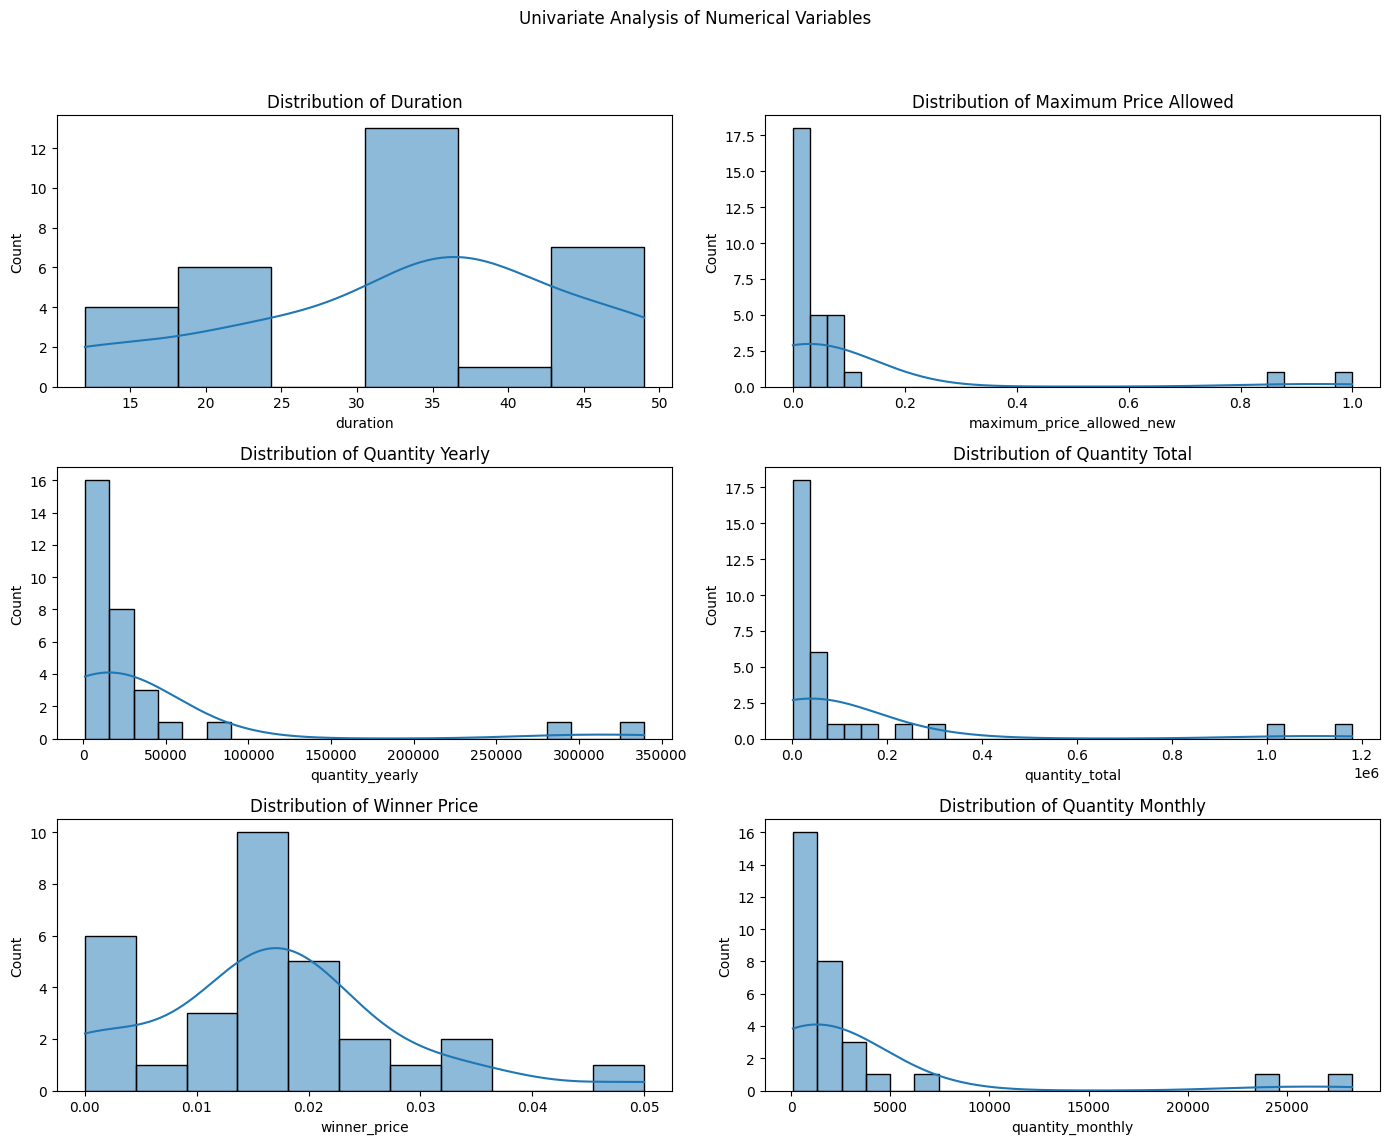

In [17]:
# Univariate Analysis - Numeric Variables
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Univariate Analysis of Numerical Variables')

# Duration
sns.histplot(df['duration'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Duration')

# Maximum Price Allowed
sns.histplot(df['maximum_price_allowed_new'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Maximum Price Allowed')

# Quantity Annual
sns.histplot(df['quantity_yearly'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Quantity Yearly')

# Quantity Total
sns.histplot(df['quantity_total'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Quantity Total')

# Winner Price
sns.histplot(df['winner_price'], kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Winner Price')

# Quantity Monthly
sns.histplot(df['quantity_monthly'], kde=True, ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Quantity Monthly')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




Univariate Analysis Results:

The histograms provide insights into the distributions of several key numerical variables:

- **Duration:** Shows a relatively varied distribution of contract durations.
- **Maximum Price Allowed:** Highly skewed towards lower values, with potential outliers at the higher end.
- **Quantity Yearly:** Also skewed, suggesting most contracts involve smaller quantities with some exceptions.
- **Quantity Total:** Similar to the yearly quantity, indicating consistency between annual and total quantities.
- **Winner Price:** Skewed towards lower values, with a few higher prices indicating competitive discrepancies.
- **Quantity Monthly:** Displays right skewness similar to other quantity metrics, reinforcing the pattern seen in other quantity distributions.


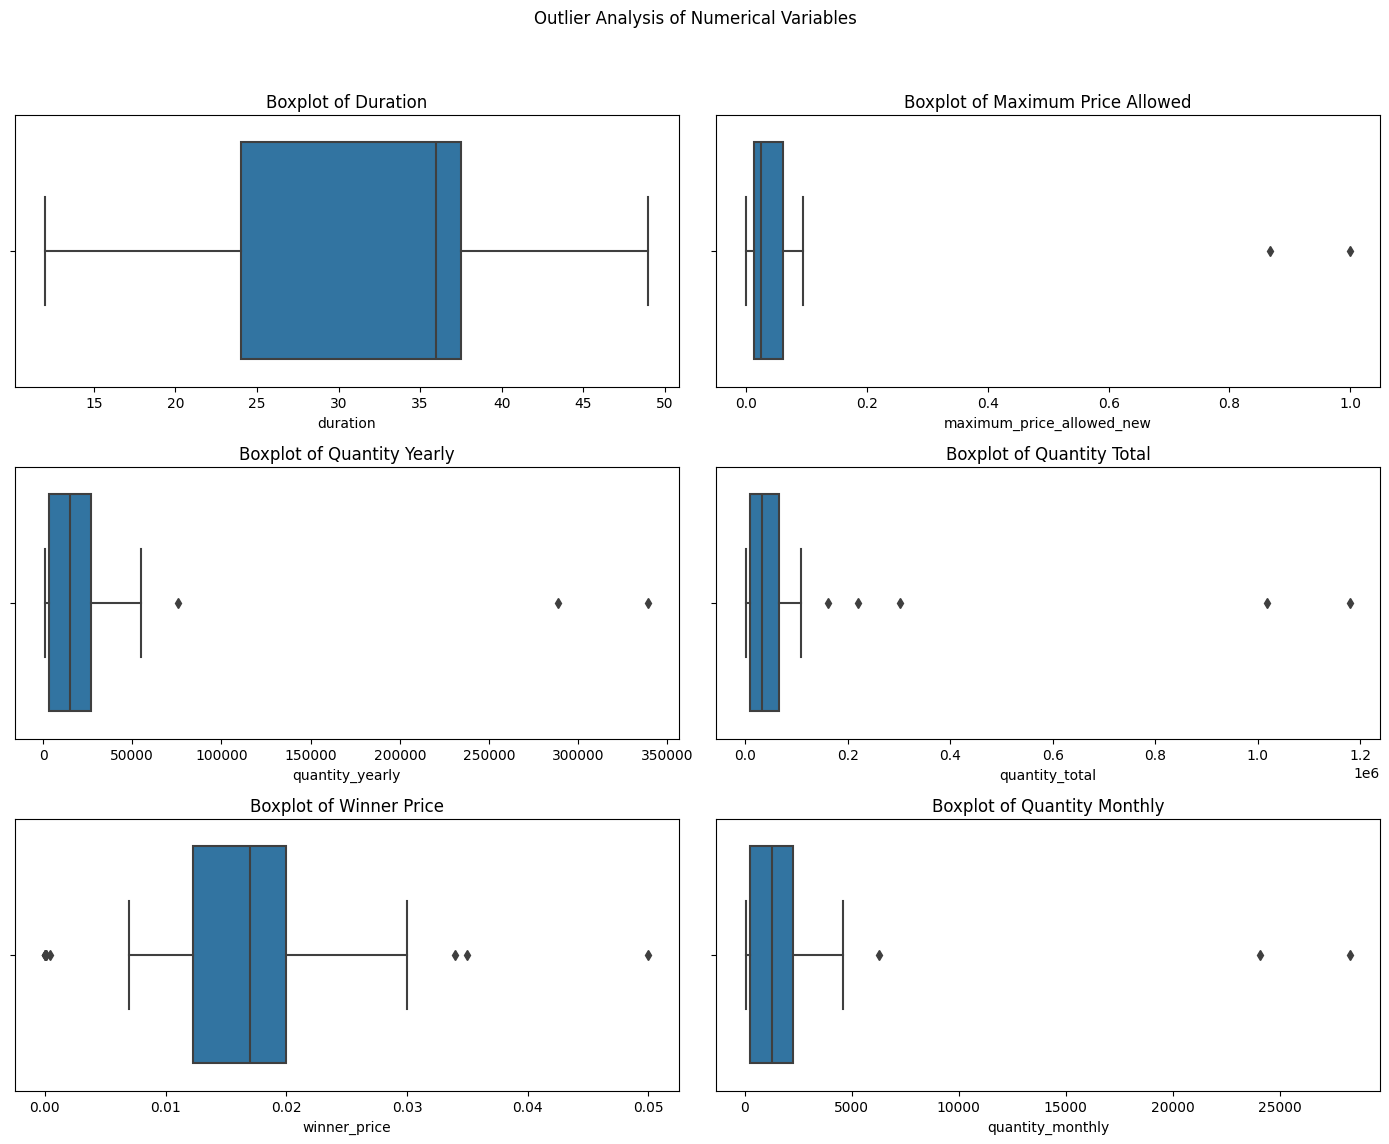

In [18]:
# Outlier detection using boxplots for key numerical variables
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Outlier Analysis of Numerical Variables')

# Duration
sns.boxplot(x=df['duration'], ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of Duration')

# Maximum Price Allowed
sns.boxplot(x=df['maximum_price_allowed_new'], ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of Maximum Price Allowed')

# Quantity Yearly
sns.boxplot(x=df['quantity_yearly'], ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of Quantity Yearly')

# Quantity Total
sns.boxplot(x=df['quantity_total'], ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of Quantity Total')

# Winner Price
sns.boxplot(x=df['winner_price'], ax=axes[2, 0])
axes[2, 0].set_title('Boxplot of Winner Price')

# Quantity Monthly
sns.boxplot(x=df['quantity_monthly'], ax=axes[2, 1])
axes[2, 1].set_title('Boxplot of Quantity Monthly')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Outlier Analysis Results:

The boxplots provide a clearer picture of the distribution of key numerical variables and highlight potential outliers:

- **Duration:** There are no significant outliers, suggesting a consistent range of contract durations across the dataset.
- **Maximum Price Allowed:** Several outliers on the upper end indicate that a few contracts have a significantly higher maximum price than typical contracts.
- **Quantity Yearly** and **Quantity Total:** Both variables show outliers on the higher end, indicating that some contracts involve substantially larger quantities.
- **Winner Price:** There are outliers present, indicating a few contracts where the winning price was significantly lower than the majority.
- **Quantity Monthly:** This also shows outliers at the high end, consistent with outliers in the annual and total quantity data.


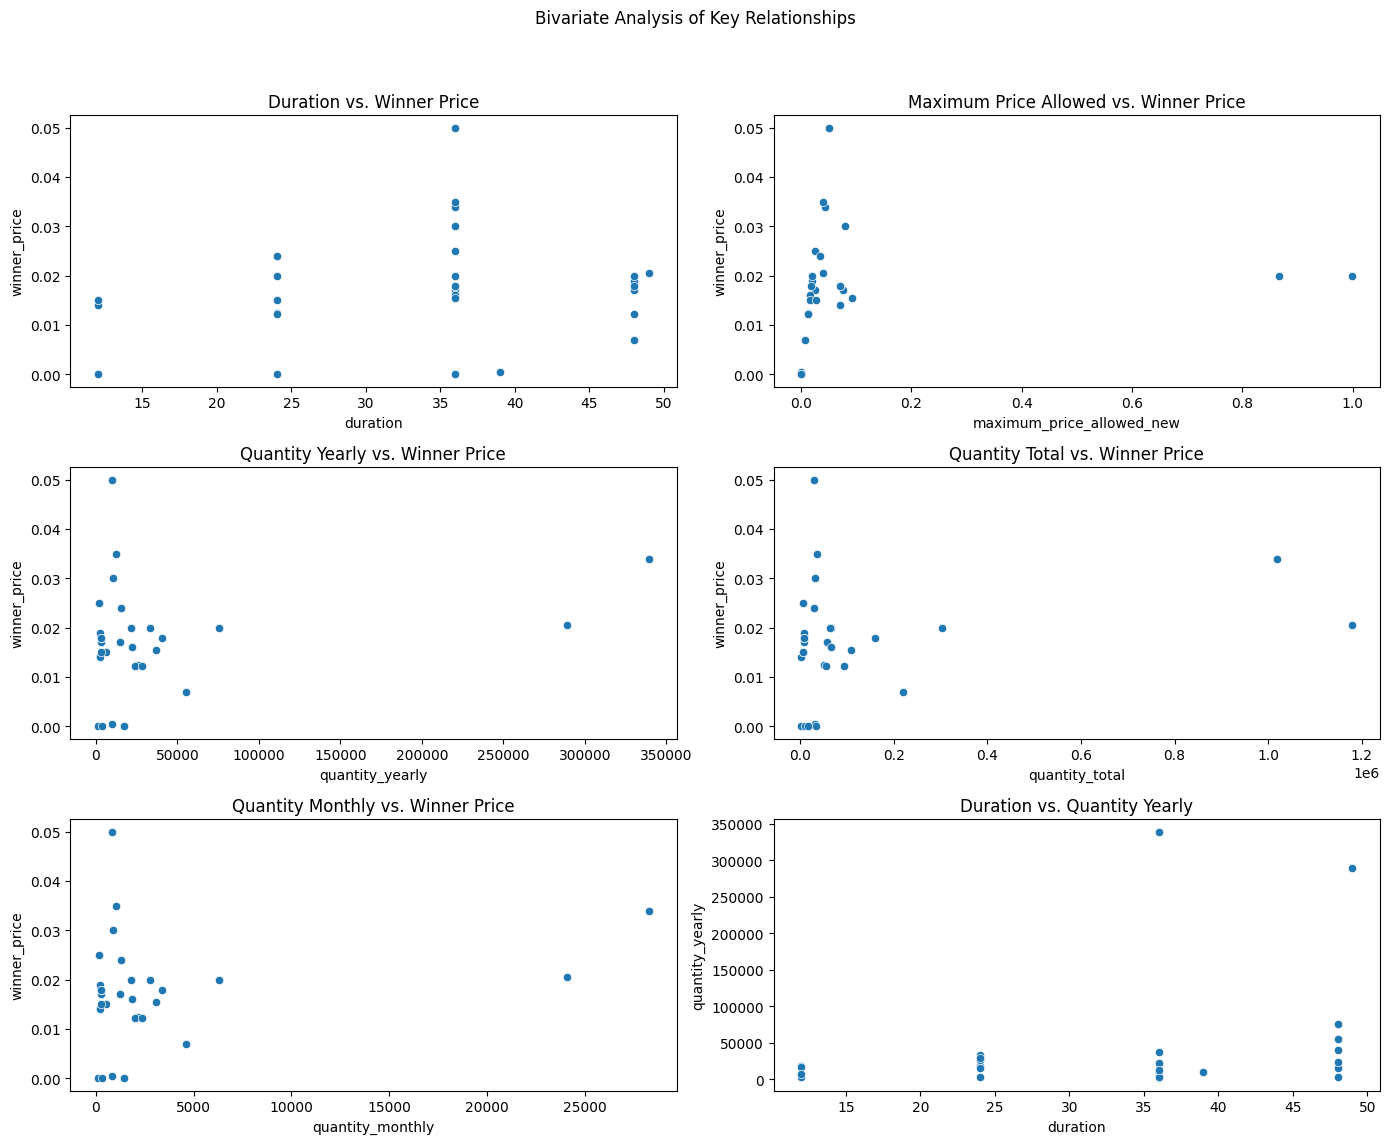

In [19]:
# Bivariate Analysis - focusing on relationships between key variables
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Bivariate Analysis of Key Relationships')

# Relationship between Duration and Winner Price
sns.scatterplot(x='duration', y='winner_price', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Duration vs. Winner Price')

# Relationship between Maximum Price Allowed and Winner Price
sns.scatterplot(x='maximum_price_allowed_new', y='winner_price', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Maximum Price Allowed vs. Winner Price')

# Relationship between Quantity Yearly and Winner Price
sns.scatterplot(x='quantity_yearly', y='winner_price', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Quantity Yearly vs. Winner Price')

# Relationship between Quantity Total and Winner Price
sns.scatterplot(x='quantity_total', y='winner_price', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Quantity Total vs. Winner Price')

# Relationship between Quantity Monthly and Winner Price
sns.scatterplot(x='quantity_monthly', y='winner_price', data=df, ax=axes[2, 0])
axes[2, 0].set_title('Quantity Monthly vs. Winner Price')

# Relationship between Duration and Quantity Yearly
sns.scatterplot(x='duration', y='quantity_yearly', data=df, ax=axes[2, 1])
axes[2, 1].set_title('Duration vs. Quantity Yearly')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Bivariate Analysis Results:

The scatter plots explore relationships between several key variables, providing insights into how they might influence each other:

- **Duration vs. Winner Price:**
  There does not appear to be a clear linear relationship between the duration of contracts and the winner price. The distribution is quite scattered.
- **Maximum Price Allowed vs. Winner Price:**
  Similarly, no strong correlation is evident between the maximum price allowed and the winner price. This suggests that other factors might be influencing the final agreed prices.
- **Quantity Yearly vs. Winner Price:**
  The plot shows a possible trend where higher annual quantities might correlate with lower winner prices, which could be due to volume discounts or competitive bidding for larger contracts.
- **Quantity Total vs. Winner Price:**
  This relationship appears similar to the annual quantity, indicating that total contract quantity and annual quantity closely mirror each other in their effect on pricing.
- **Quantity Monthly vs. Winner Price:**
  The relationship here also hints at lower prices for higher monthly quantities, aligning with bulk purchasing benefits.
- **Duration vs. Quantity Annual:**
  No strong correlation is observed between the duration of contracts and annual quantities. Contracts of various lengths seem to accommodate a wide range of quantities.


In [20]:
# Interactive scatter plot using Plotly for Region vs. Winner Price
fig = px.scatter(df, x="region", y="winner_price", color="region",
                 title="Interactive Plot of Region vs. Winner Price",
                 labels={"region": "Region", "winner_price": "Winner Price"},
                 hover_data=["buyer", "contract_type"])

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()


In [21]:
# Interactive scatter plot using Plotly for Region vs. Total Quantity
fig = px.scatter(df, x="region", y="quantity_total", color="region",
                 title="Interactive Plot of Region vs. Winner Price",
                 labels={"region": "Region", "quantity_total": "Total Quantity"},
                 hover_data=["buyer", "contract_type"])

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

**Handling Outliers**

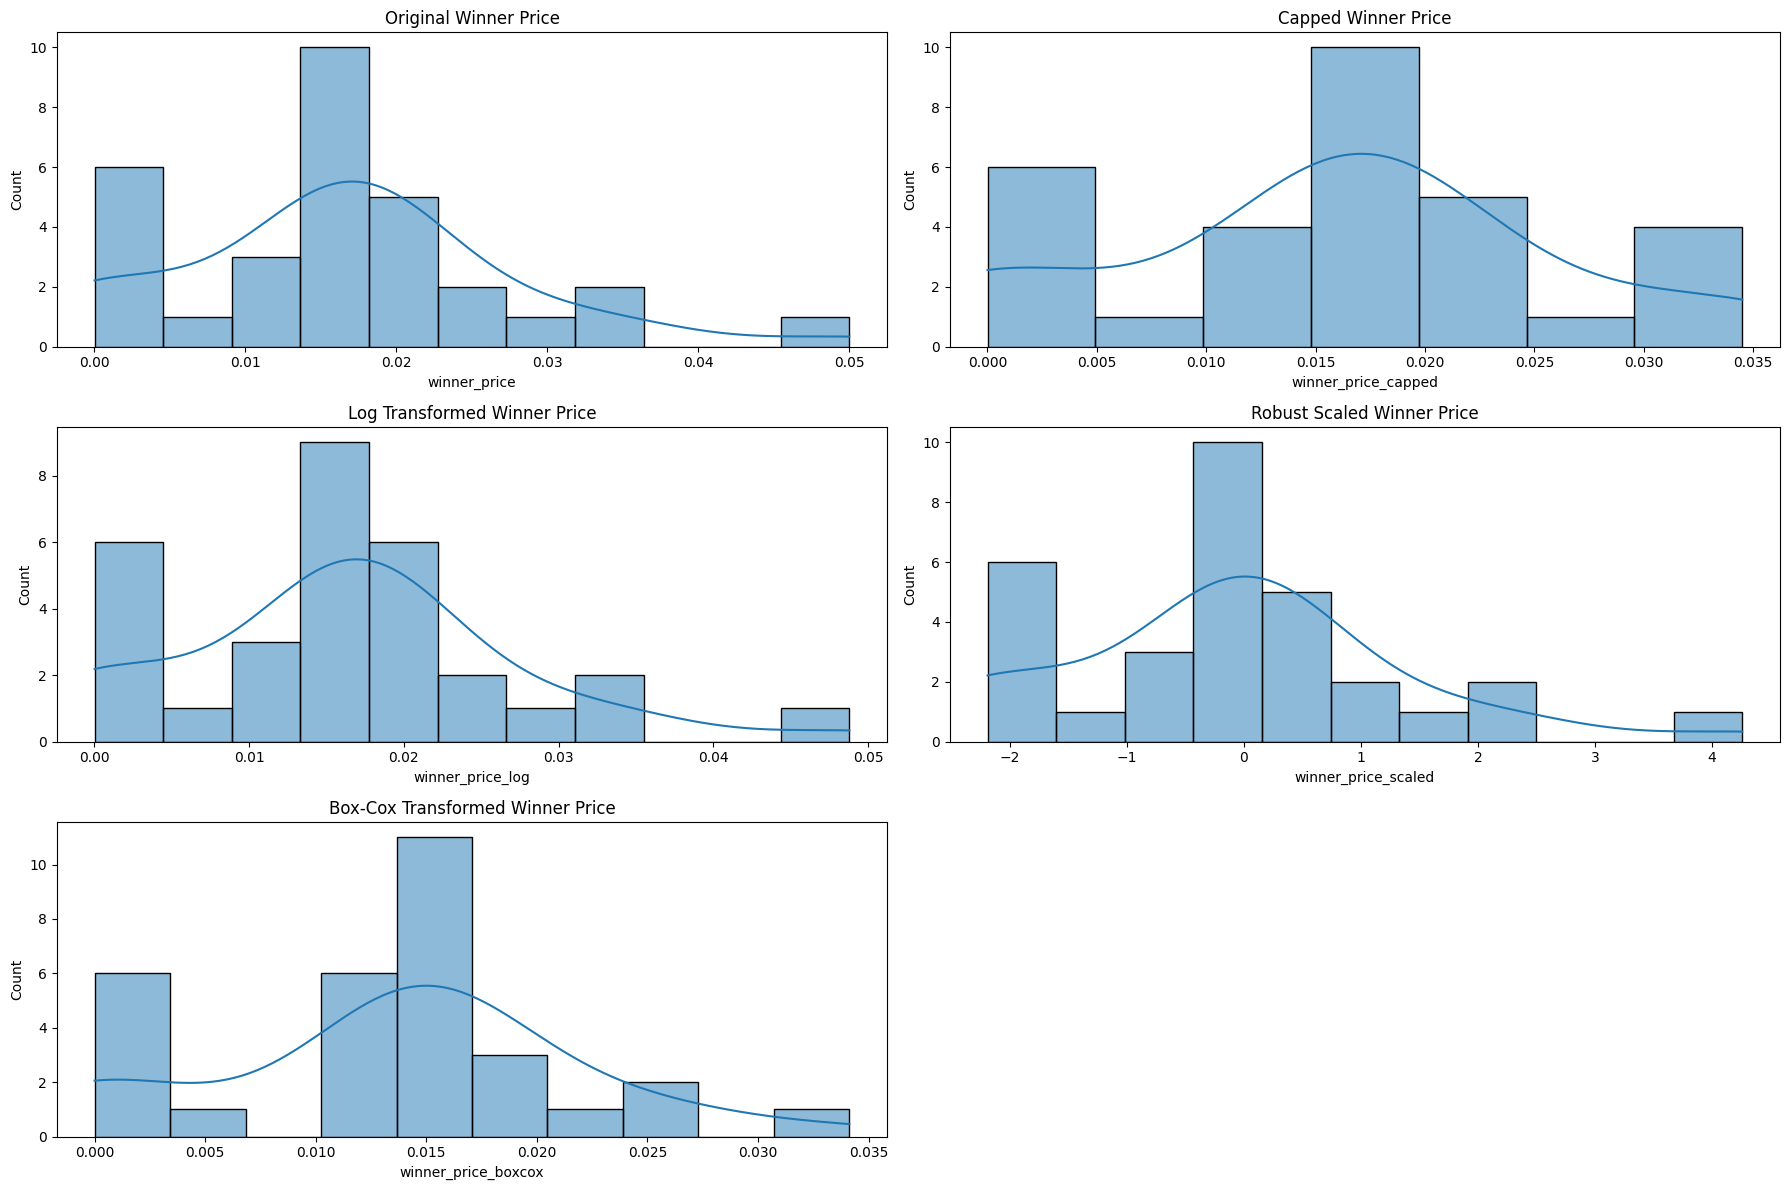

In [22]:
# Capping
upper_limit = df['winner_price'].quantile(0.95)
lower_limit = df['winner_price'].quantile(0.05)
df['winner_price_capped'] = df['winner_price'].clip(lower=lower_limit, upper=upper_limit)

# Log Transformation
df['winner_price_log'] = np.log1p(df['winner_price'])

# Robust Scaling
scaler = RobustScaler()
df['winner_price_scaled'] = scaler.fit_transform(df[['winner_price']].values)

# Box-Cox Transformation
shifted_data = df['winner_price'] - df['winner_price'].min() + 1  # ensure all values are positive
df['winner_price_boxcox'], _ = boxcox(shifted_data)

# Plotting the transformations
plt.figure(figsize=(18, 12))

# Original Data
plt.subplot(3, 2, 1)
sns.histplot(df['winner_price'], kde=True)
plt.title('Original Winner Price')

# Capped Data
plt.subplot(3, 2, 2)
sns.histplot(df['winner_price_capped'], kde=True)
plt.title('Capped Winner Price')

# Log Transformed Data
plt.subplot(3, 2, 3)
sns.histplot(df['winner_price_log'], kde=True)
plt.title('Log Transformed Winner Price')

# Robust Scaled Data
plt.subplot(3, 2, 4)
sns.histplot(df['winner_price_scaled'], kde=True)
plt.title('Robust Scaled Winner Price')

# Box-Cox Transformed Data
plt.subplot(3, 2, 5)
sns.histplot(df['winner_price_boxcox'], kde=True)
plt.title('Box-Cox Transformed Winner Price')

plt.tight_layout()
plt.show()

**Recommended Approach Based on Visualization**

  - From the visual analysis:


    - **If Linear Models are to be Used**: The Box-Cox Transformation seems to provide the most normal-like distribution, which could enhance the performance of algorithms that assume normality.

    - **For Robustness to Outliers in General Models**: The Robust Scaling method maintains the overall distribution shape while reducing the influence of outliers, making it suitable for a broad range of models.

    - **For Minimizing Data Alteration**: Capping might be preferable if retaining the original data structure as much as possible is important, especially when extreme values are still meaningful within the business context.
    
    
  - Given these insights, the choice between Box-Cox transformation, robust scaling, or capping should be guided by the specific requirements of the machine learning models you plan to use and the statistical properties you wish to enhance or preserve in the dataset. Each method has its strengths, and the final selection can depend on further model testing and validation.